In [34]:
import matplotlib.pyplot as plt
import pandas as pd
import math

def createEquallySpacedPoints(a,b,N):
    """ 
    (x_0,...,x_N) -- N+1 точка

    """
    X = []
    H = []
    x_ = a
    for i in range(N+1):
        x = a + i * (b-a)/N
        # y = f(x)
        X.append(x)
        H.append(x-x_)
        x_ = x  
    H.pop(0)
    return X, H

def createPointsFromFile2(filename):
    """ 
    (x_0,...,x_N) -- N+1 точка
    """
    X = []
    F = []
    W = []
    H = []
    
    with open(filename, 'r') as file:
        lines = file.readlines()        
        if lines:
            for line in lines:
                values = line.strip().split()
                if len(values) >= 3:
                    x = float(values[0])
                    fVal = float(values[1])
                    w = float(values[2])
                    
                    X.append(x)
                    F.append(fVal)
                    W.append(w)
            
            if len(X) > 1:
                for i in range(1, len(X)):
                    H.append(X[i] - X[i-1])
    return X, F, W, H

def createVecF(X, fFromFile):
    """ 
    F = (f'(x_0), f(x_1), ..., f(x_{N-1}), f'(x_N))
    Для файловых данных используем численные производные на границах
    """
    N = len(X) - 1
    F = [0.0] * (N + 1)  
    
    if len(X) >= 2:
        m0 = 1
        mN = 1
    else:
        m0 = 0
        mN = 0
    
    F[0] = m0
    for i in range(1, N):
        F[i] = fFromFile[i]
    F[N] = mN
    
    return F

def createRightSide(H, F):
    N = len(F) - 1
    B = [0.0] * (N + 1)
    B[0] = F[0] 
    B[N] = F[N] 
    
    for i in range(1, N):
        h_ = H[i-1]
        h = H[i]
        
        B[i] = ( - 1.0/(h_*h_) * F[i-1] \
                 + (1.0/(h_*h_) - 1.0/(h*h)) * F[i] \
                 + 1.0/(h*h) * F[i+1] ) * 3.0 
               
    return B

def createMatrix(N, H):
    M = [[0.0 for _ in range(N+1)] for _ in range(N+1)]
    
    for i in range(N+1):  
        if i == 0:
            M[0][0] = 1.0
        elif i == N:   
            M[N][N] = 1.0 
        else:
            h_ = H[i-1]   
            h  = H[i]        
            M[i][i - 1] = 1.0 / h_
            M[i][i] = 2.0 / h_ + 2.0 / h 
            M[i][i + 1] = 1.0 / h 
    return M

def solveTridiag(M, f):
    N = len(f) - 1

    alpha = [0.0] * (N+1)  
    beta  = [0.0] * (N+1)
    y = [0.0] * (N+1)

    a = [0.0] * (N+1)  
    b = [0.0] * (N+1) 
    c = [0.0] * (N+1)  
    
    b[0] = 0.0
    a[N] = 0.0

    for i in range(N+1):
        c[i] = M[i][i]
        if (i > 0 and i < N):
            a[i] = -1.0 * M[i][i-1]
            b[i] = -1.0 * M[i][i+1]
    
    # Прямой ход 
    alpha[1] = b[0] / c[0]
    beta[1] = f[0] / c[0]
    
    for i in range(1, N):
        denom = c[i] - a[i] * alpha[i]
        alpha[i + 1] = b[i] / denom
        beta[i + 1] = (f[i] + a[i] * beta[i]) / denom
    
    denom = c[N] - a[N] * alpha[N]
    y[N] = (f[N] + a[N] * beta[N]) / denom
    
    # Обратный ход 
    for i in range(N-1, -1, -1):
        y[i] = alpha[i + 1] * y[i + 1] + beta[i + 1]
    
    return y

def buildSpline(x, xi, xi_, h, m_, m, fi_, fi):
    A = (x-xi) * (x-xi) * (x-xi_) / (h*h)
    B = (x-xi_)*(x-xi_) * (x-xi) / (h*h)
    C = (x-xi) * (x-xi) * (2.*(x - xi_) + h) / (h*h*h)
    D = (x-xi_)*(x-xi_) * (2.*(x - xi) - h)  / (-h*h*h) 

    return A*m_ + B*m + C*fi_ + D*fi

def buildAllSplines(X, y, fFromFile):
    N = len(X) - 1
   
    splines = []
    
    for i in range(1, N+1):
        xi_ = X[i-1]      
        xi  = X[i]   
        h   = xi - xi_   
        
        m_ = y[i-1]      
        m  = y[i]    
        fi_ = fFromFile[i-1]   
        fi  = fFromFile[i]  
        
        def spline_func(x, xi=xi, xi_=xi_, h=h, m_=m_, m=m, fi_=fi_, fi=fi):
            return buildSpline(x, xi, xi_, h, m_, m, fi_, fi)
        
        splines.append((xi_, xi, spline_func))
    
    return splines

def splineValue(x, splines):
    for (xLeft, xRight, Sloc) in splines:
        if xLeft <= x <= xRight:
            return Sloc(x)
    if x < splines[0][0]:
        return splines[0][2](x)
    return splines[-1][2](x)

def insertPointsX(X, k):
    extendedX = []
    for i in range(len(X) - 1):
        x_ = X[i]
        x = X[i + 1]
        extendedX.append(x_)
        for j in range(1, k + 1):
            xNew = x_ + j * (x - x_) / (k + 1)
            extendedX.append(xNew)
    extendedX.append(X[-1])
    return extendedX



 X = [0.0, 2.0, 3.0, 5.0, 6.0, 8.0, 9.0, 11.0, 12.0, 14.0, 15.0]
 H = [2.0, 1.0, 2.0, 1.0, 2.0, 1.0, 2.0, 1.0, 2.0, 1.0]
 F_file = [10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.5, 15.0, 50.0, 60.0, 85.0]
 B = [1, 6.75, 0.0, 0.0, 0.0, 1.5, 4.875, 108.375, 112.5, -169.5, 1]


Матрица системы:
['1.0000', '0.0000', '0.0000', '0.0000', '0.0000', '0.0000', '0.0000', '0.0000', '0.0000', '0.0000', '0.0000']
['0.5000', '3.0000', '1.0000', '0.0000', '0.0000', '0.0000', '0.0000', '0.0000', '0.0000', '0.0000', '0.0000']
['0.0000', '1.0000', '3.0000', '0.5000', '0.0000', '0.0000', '0.0000', '0.0000', '0.0000', '0.0000', '0.0000']
['0.0000', '0.0000', '0.5000', '3.0000', '1.0000', '0.0000', '0.0000', '0.0000', '0.0000', '0.0000', '0.0000']
['0.0000', '0.0000', '0.0000', '1.0000', '3.0000', '0.5000', '0.0000', '0.0000', '0.0000', '0.0000', '0.0000']
['0.0000', '0.0000', '0.0000', '0.0000', '0.5000', '3.0000', '1.0000', '0.0000', '0.0000', '0.0000', '0.0000']
['0.0000', '0.0000', '0.0000', '0.0000', '0.0000

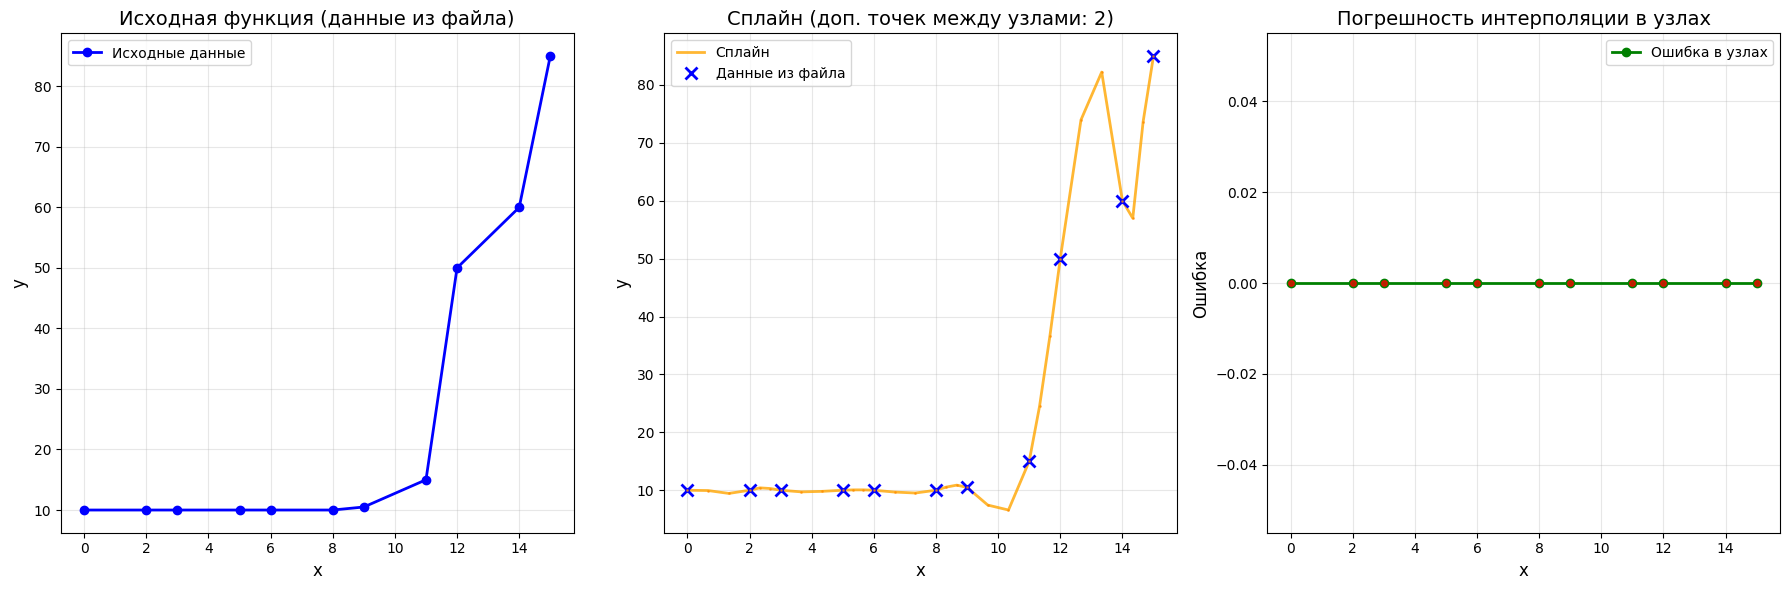


Максимальная ошибка в узлах: 0.000000e+00


In [35]:
X, F_file, W, H = createPointsFromFile2("nodes2.txt")
N = len(X) - 1

print(f" X = {X}")
print(f" H = {H}")
print(f" F_file = {F_file}")

F_vec = createVecF(X, F_file)
B = createRightSide(H, F_vec)
A = createMatrix(N, H)
y = solveTridiag(A, B)

print(f" B = {B}\n\n")

print("Матрица системы:")
for row in A:
    print([f"{val:.4f}" for val in row])
print(f" y =  {y}")

print(f"m[0] = {y[0]}, оцененная f'({X[0]}) = {F_vec[0]}")
print(f"m[{N}] = {y[N]}, оцененная f'({X[N]}) = {F_vec[N]}")

splines = buildAllSplines(X, y, F_file)

print("Значения сплайна в узлах:")
for i, x in enumerate(X):
    val = splineValue(x, splines)
    file_val = F_file[i]
    error = abs(val - file_val)
    print(f"S({x:.3f}) = {val:.6f}   (f(x) из файла = {file_val:.6f}, ошибка = {error:.6f})")

# plt.figure(figsize=(15, 6))

kPoints = 2
plt.figure(figsize=(18, 6))

# График 1: Исходная функция (просто соединенные точки)
plt.subplot(1, 3, 1)
plt.plot(X, F_file, 'bo-', linewidth=2, markersize=6, label='Исходные данные')
plt.title('Исходная функция (данные из файла)', fontsize=14)
plt.xlabel('x', fontsize=12)
plt.ylabel('y', fontsize=12)
plt.legend()
plt.grid(True, alpha=0.3)

# График 2: сплайн с промежуточными точками
plt.subplot(1, 3, 2)
XX = insertPointsX(X, k= kPoints)
spline_vals = [splineValue(x, splines) for x in XX]

plt.plot(XX, spline_vals, '-', color='orange', linewidth=2, label='Сплайн', alpha=0.8)
plt.plot(X, F_file, 'bx', markersize=8, linewidth=2, label='Данные из файла', markeredgewidth=2)
plt.plot(XX, spline_vals, '.', color='darkorange', markersize=2, alpha=0.6)

plt.title(f'Сплайн (доп. точек между узлами: {kPoints})', fontsize=14)
plt.xlabel('x', fontsize=12)
plt.ylabel('y', fontsize=12)
plt.legend()
plt.grid(True, alpha=0.3)

# График 3: ошибки в узлах
plt.subplot(1, 3, 3)
errors_nodes = []
for i, x in enumerate(X):
    spline_val = splineValue(x, splines)
    error = abs(spline_val - F_file[i])
    errors_nodes.append(error)

plt.plot(X, errors_nodes, 'go-', markersize=6, linewidth=2, label='Ошибка в узлах')
plt.plot(X, errors_nodes, 'ro', markersize=4, alpha=0.7)
plt.title('Погрешность интерполяции в узлах', fontsize=14)
plt.xlabel('x', fontsize=12)
plt.ylabel('Ошибка', fontsize=12)
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

max_error = max(errors_nodes)
print(f"\nМаксимальная ошибка в узлах: {max_error:.6e}")

# Сохранение результатов
with open("spline_results.txt", "w") as fout:
    fout.write(f"{'x':>10} {'f(x)_file':>15} {'S(x)':>15} {'Error':>15}\n")
    fout.write("-" * 60 + "\n")
    for i, x in enumerate(X):
        spline_val = splineValue(x, splines)
        error = abs(spline_val - F_file[i])
        fout.write(f"{x:10.6f} {F_file[i]:15.8f} {spline_val:15.8f} {error:15.8e}\n")
    
    # Дополнительно сохраняем информацию о количестве точек
    fout.write(f"\nКоличество дополнительных точек между узлами: {kPoints}\n")

In [38]:
import matplotlib.pyplot as plt
import pandas as pd
import math
import numpy as np

def createPointsFromFile2(filename):
    """ 
    (x_0,...,x_N) -- N+1 точка
    """
    X = []
    F = []
    W = []  # веса
    H = []
    
    with open(filename, 'r') as file:
        lines = file.readlines()        
        if lines:
            for line in lines:
                values = line.strip().split()
                if len(values) >= 3:
                    x = float(values[0])
                    f_val = float(values[1])
                    w = float(values[2])
                    
                    X.append(x)
                    F.append(f_val)
                    W.append(w)
            
            if len(X) > 1:
                for i in range(1, len(X)):
                    H.append(X[i] - X[i-1])
    return X, F, W, H

def createVecF(X, F_file):
    """ 
    F = (f'(x_0), f(x_1), ..., f(x_{N-1}), f'(x_N))
    Для файловых данных используем численные производные на границах
    """
    N = len(X) - 1
    F = [0.0] * (N + 1) 
    
    if len(X) >= 2:
        m0 = 1
        mN = 1
    else:
        m0 = 0
        mN = 0
    
    F[0] = m0
    for i in range(1, N):
        F[i] = F_file[i]
    F[N] = mN
    
    return F

def createRightSide(H, F):
    N = len(F) - 1
    B = [0.0] * (N + 1)
    B[0] = F[0] 
    B[N] = F[N] 
    
    for i in range(1, N):
        h_ = H[i-1]
        h = H[i]
        
        B[i] = ( - 1.0/(h_*h_) * F[i-1] \
                 + (1.0/(h_*h_) - 1.0/(h*h)) * F[i] \
                 + 1.0/(h*h) * F[i+1] ) * 3.0 
               
    return B

def createMatrixWithWeights(N, H, W):
    """
    Создает матрицу для сплайна с натяжением
    M[i][i-1] = w_ / h_
    M[i][i] = 2.0 * (w_ / h_ + w / h)
    M[i][i+1] = w / h
    """
    M = [[0.0 for _ in range(N+1)] for _ in range(N+1)]
    
    for i in range(N+1):  
        if i == 0:
            M[0][0] = 1.0
        elif i == N:   
            M[N][N] = 1.0 
        else:
            h_ = H[i-1]   
            h  = H[i]        
            w_ = W[i-1]  # вес для левого отрезка
            w  = W[i]    # вес для правого отрезка
            
            M[i][i - 1] = w_ / h_
            M[i][i] = 2.0 * (w_ / h_ + w / h)
            M[i][i + 1] = w / h
    return M

def solveTridiag(M, f):
    N = len(f) - 1

    alpha = [0.0] * (N+1)  
    beta  = [0.0] * (N+1)
    y = [0.0] * (N+1)

    a = [0.0] * (N+1)  
    b = [0.0] * (N+1) 
    c = [0.0] * (N+1)  
    
    b[0] = 0.0
    a[N] = 0.0

    for i in range(N+1):
        c[i] = M[i][i]
        if (i > 0 and i < N):
            a[i] = -1.0 * M[i][i-1]
            b[i] = -1.0 * M[i][i+1]
    
    # Прямой ход 
    alpha[1] = b[0] / c[0]
    beta[1] = f[0] / c[0]
    
    for i in range(1, N):
        denom = c[i] - a[i] * alpha[i]
        alpha[i + 1] = b[i] / denom
        beta[i + 1] = (f[i] + a[i] * beta[i]) / denom
    
    denom = c[N] - a[N] * alpha[N]
    y[N] = (f[N] + a[N] * beta[N]) / denom
    
    # Обратный ход 
    for i in range(N-1, -1, -1):
        y[i] = alpha[i + 1] * y[i + 1] + beta[i + 1]
    
    return y

def buildSpline(x, xi, xi_, h, m_, m, fi_, fi):
    A = (x-xi) * (x-xi) * (x-xi_) / (h*h)
    B = (x-xi_)*(x-xi_) * (x-xi) / (h*h)
    C = (x-xi) * (x-xi) * (2.*(x - xi_) + h) / (h*h*h)
    D = (x-xi_)*(x-xi_) * (2.*(x - xi) - h)  / (-h*h*h) 

    return A*m_ + B*m + C*fi_ + D*fi

def buildAllSplines(X, y, F_file):
    N = len(X) - 1
   
    splines = []
    
    for i in range(1, N+1):
        xi_ = X[i-1]      
        xi  = X[i]   
        h   = xi - xi_   
        
        m_ = y[i-1]      
        m  = y[i]    
        fi_ = F_file[i-1]   
        fi  = F_file[i]  
        
        def spline_func(x, xi=xi, xi_=xi_, h=h, m_=m_, m=m, fi_=fi_, fi=fi):
            return buildSpline(x, xi, xi_, h, m_, m, fi_, fi)
        
        splines.append((xi_, xi, spline_func))
    
    return splines

def splineValue(x, splines):
    for (xLeft, xRight, Sloc) in splines:
        if xLeft <= x <= xRight:
            return Sloc(x)
    if x < splines[0][0]:
        return splines[0][2](x)
    return splines[-1][2](x)

def insertPointsX(X, k):
    extendedX = []
    for i in range(len(X) - 1):
        x_ = X[i]
        x = X[i + 1]
        extendedX.append(x_)
        for j in range(1, k + 1):
            xNew = x_ + j * (x - x_) / (k + 1)
            extendedX.append(xNew)
    extendedX.append(X[-1])
    return extendedX

def checkMonotonicity(spline_func, X, num_points=100):
    """
    Проверяет монотонность сплайна на каждом отрезке
    Возвращает список с информацией о монотонности на каждом отрезке
    """
    monotonic_info = []
    
    for i in range(len(X) - 1):
        x_left = X[i]
        x_right = X[i+1]
        
        xx = np.linspace(x_left, x_right, num_points)
        yy = [spline_func(x) for x in xx]
        
        increasing = all(yy[j] <= yy[j+1] for j in range(len(yy)-1))
        decreasing = all(yy[j] >= yy[j+1] for j in range(len(yy)-1))
        
        is_monotonic = increasing or decreasing
        
        # немонотонные участки
        extr_count = 0
        for j in range(1, len(yy)-1):
            if (yy[j] > yy[j-1] and yy[j] > yy[j+1]) or (yy[j] < yy[j-1] and yy[j] < yy[j+1]):
                extr_count += 1
        
        monotonic_info.append({
            'interval': (x_left, x_right),
            'monotonic': is_monotonic,
            'extrema_count': extr_count,
            'increasing': increasing,
            'decreasing': decreasing
        })
    
    return monotonic_info

def findNonMonotonicIntervals(monotonic_info):
    """Находит интервалы, где сплайн не монотонен"""
    non_monotonic = []
    for i, info in enumerate(monotonic_info):
        if not info['monotonic']:
            non_monotonic.append((i, info))
    return non_monotonic

def adjustWeightsForMonotonicity(W, non_monotonic_intervals, X, factor=10.0):
    """
    Корректирует веса для улучшения монотонности
    Увеличивает веса на немонотонных участках
    """
    new_W = W.copy()
    
    for interval_idx, info in non_monotonic_intervals:
        # Увеличиваем вес в левом и правом узлах интервала
        new_W[interval_idx] *= factor  # левый узел
        new_W[interval_idx + 1] *= factor  # правый узел
        
        print(f"  Увеличиваем веса на интервале [{X[interval_idx]:.3f}, {X[interval_idx+1]:.3f}] в {factor} раз")
    
    return new_W

def improveMonotonicity(X, F_file, H, W_initial, max_iterations=10):
    """
    Итеративно улучшает монотонность сплайна путем подбора весов
    """
    print("Начинаем улучшение монотонности сплайна...")
    
    W_current = W_initial.copy()
    F_vec = createVecF(X, F_file)
    B = createRightSide(H, F_vec)
    
    for iteration in range(max_iterations):
        print(f"\n--- Итерация {iteration + 1} ---")
        print(f"Текущие веса: {[f'{w:.2f}' for w in W_current]}")
        
        # Строим сплайн с текущими весами
        A = createMatrixWithWeights(len(X)-1, H, W_current)
        y = solveTridiag(A, B)
        splines = buildAllSplines(X, y, F_file)
        
        # Проверяем монотонность
        monotonic_info = checkMonotonicity(lambda x: splineValue(x, splines), X)
        non_monotonic = findNonMonotonicIntervals(monotonic_info)
        
        print(f"Немонотонные интервалы: {len(non_monotonic)}")
        
        if len(non_monotonic) == 0:
            print("монотонность есть на всех интервалах!")
            return W_current, splines, True
        
        # корректируем веса
        W_current = adjustWeightsForMonotonicity(W_current, non_monotonic, X)
    
    print(f"максимальное количество итераций ({max_iterations})")
    return W_current, splines, False



Узлы: [0.0, 2.0, 3.0, 5.0, 6.0, 8.0, 9.0, 11.0, 12.0, 14.0, 15.0]
Шаги: [2.0, 1.0, 2.0, 1.0, 2.0, 1.0, 2.0, 1.0, 2.0, 1.0]
Значения функции: [10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.5, 15.0, 50.0, 60.0, 85.0]
Начальные веса: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
Количество дополнительных точек между узлами: 5

Проверка монотонности начального сплайна:
Немонотонные интервалы в начальном сплайне: 9
  Интервал [0.000, 2.000]: 2 экстремумов
  Интервал [2.000, 3.000]: 1 экстремумов
  Интервал [3.000, 5.000]: 1 экстремумов
  Интервал [5.000, 6.000]: 1 экстремумов
  Интервал [6.000, 8.000]: 1 экстремумов
  Интервал [8.000, 9.000]: 1 экстремумов
  Интервал [9.000, 11.000]: 1 экстремумов
  Интервал [12.000, 14.000]: 1 экстремумов
  Интервал [14.000, 15.000]: 1 экстремумов
Начинаем улучшение монотонности сплайна...

--- Итерация 1 ---
Текущие веса: ['1.00', '1.00', '1.00', '1.00', '1.00', '1.00', '1.00', '1.00', '1.00', '1.00', '1.00']
Немонотонные интервалы: 9
  Увеличиваем вес

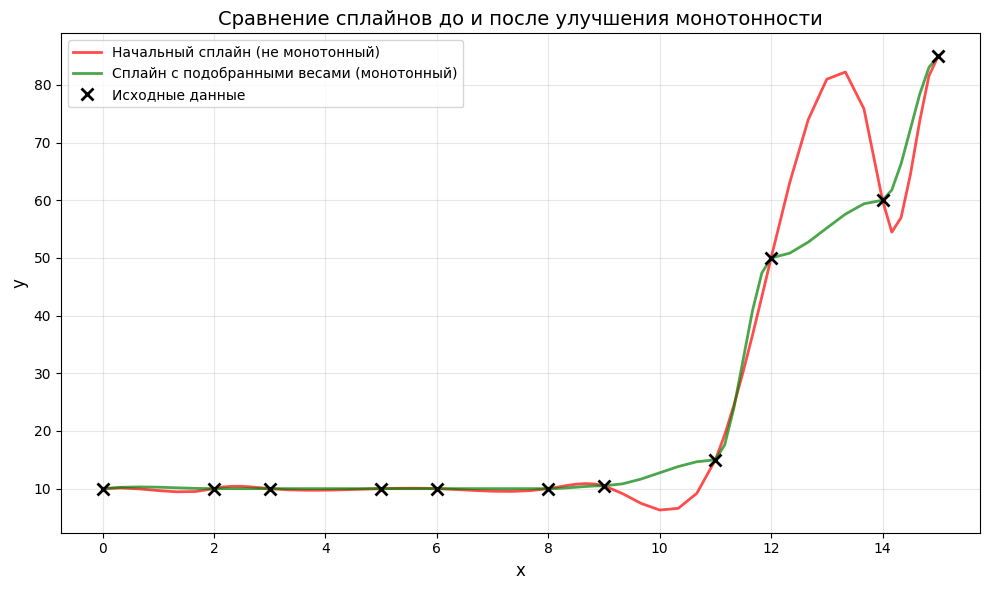


Максимальные ошибки в узлах:
Начальный сплайн: 0.000000e+00
Сплайн с подобранными весами: 0.000000e+00


In [42]:

k_points = 5

X, F_file, W_initial, H = createPointsFromFile2("nodes2.txt")
N = len(X) - 1

print(f"Узлы: {X}")
print(f"Шаги: {H}")
print(f"Значения функции: {F_file}")
print(f"Начальные веса: {W_initial}")
print(f"Количество дополнительных точек между узлами: {k_points}")

# Сначала строим сплайн с начальными весами
F_vec = createVecF(X, F_file)
B = createRightSide(H, F_vec)
A_initial = createMatrixWithWeights(N, H, W_initial)
y_initial = solveTridiag(A_initial, B)
splines_initial = buildAllSplines(X, y_initial, F_file)

# Проверяем монотонность начального сплайна
print("\nПроверка монотонности начального сплайна:")
monotonic_info_initial = checkMonotonicity(lambda x: splineValue(x, splines_initial), X)
non_monotonic_initial = findNonMonotonicIntervals(monotonic_info_initial)
print(f"Немонотонные интервалы в начальном сплайне: {len(non_monotonic_initial)}")

for i, info in non_monotonic_initial:
    print(f"  Интервал [{X[i]:.3f}, {X[i+1]:.3f}]: {info['extrema_count']} экстремумов")

# Улучшаем монотонность
W_final, splines_final, success = improveMonotonicity(X, F_file, H, W_initial)

print(f"\n--- РЕЗУЛЬТАТ ---")
print(f"Начальные веса: {[f'{w:.2f}' for w in W_initial]}")
print(f"Финальные веса: {[f'{w:.2f}' for w in W_final]}")
print(f"Улучшение монотонности: {'УСПЕХ' if success else 'ЧАСТИЧНЫЙ УСПЕХ'}")

# Проверяем монотонность финального сплайна
print("\nПроверка монотонности финального сплайна:")
monotonic_info_final = checkMonotonicity(lambda x: splineValue(x, splines_final), X)
non_monotonic_final = findNonMonotonicIntervals(monotonic_info_final)
print(f"Немонотонные интервалы в финальном сплайне: {len(non_monotonic_final)}")

plt.figure(figsize=(10, 6))

XX = insertPointsX(X, k=k_points)

spline_initial_vals = [splineValue(x, splines_initial) for x in XX]
spline_final_vals = [splineValue(x, splines_final) for x in XX]

plt.plot(XX, spline_initial_vals, '-', color='red', linewidth=2, label='Начальный сплайн (не монотонный)', alpha=0.7)
plt.plot(XX, spline_final_vals, '-', color='green', linewidth=2, label='Сплайн с подобранными весами (монотонный)', alpha=0.7)
plt.plot(X, F_file, 'kx', markersize=8, linewidth=2, label='Исходные данные', markeredgewidth=2)

plt.title('Сравнение сплайнов до и после улучшения монотонности', fontsize=14)
plt.xlabel('x', fontsize=12)
plt.ylabel('y', fontsize=12)
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

errors_initial = []
errors_final = []

for i, x in enumerate(X):
    val_initial = splineValue(x, splines_initial)
    val_final = splineValue(x, splines_final)
    
    errors_initial.append(abs(val_initial - F_file[i]))
    errors_final.append(abs(val_final - F_file[i]))

max_error_initial = max(errors_initial)
max_error_final = max(errors_final)

print(f"\nМаксимальные ошибки в узлах:")
print(f"Начальный сплайн: {max_error_initial:.6e}")
print(f"Сплайн с подобранными весами: {max_error_final:.6e}")

with open("monotonic_spline_results.txt", "w") as fout:
    fout.write("УЛУЧШЕНИЕ МОНОТОННОСТИ СПЛАЙНА\n")
    fout.write("=" * 60 + "\n")
    fout.write(f"Начальные веса: {W_initial}\n")
    fout.write(f"Финальные веса: {W_final}\n")
    fout.write(f"Улучшение монотонности: {'УСПЕХ' if success else 'частично лучше стало'}\n\n")
    
    fout.write("Немонотонные интервалы в начальном сплайне:\n")
    for i, info in non_monotonic_initial:
        x_left, x_right = info['interval']
        fout.write(f"  [{x_left:.3f}, {x_right:.3f}]: {info['extrema_count']} экстремумов\n")
    
    fout.write("\nНемонотонные интервалы в финальном сплайне:\n")
    for i, info in non_monotonic_final:
        x_left, x_right = info['interval']
        fout.write(f"  [{x_left:.3f}, {x_right:.3f}]: {info['extrema_count']} экстремумов\n")
    
    fout.write(f"\nМаксимальные ошибки:\n")
    fout.write(f"Начальный сплайн: {max_error_initial:.8e}\n")
    fout.write(f"Сплайн с подобранными весами: {max_error_final:.8e}\n")
    fout.write(f"Количество дополнительных точек между узлами: {k_points}\n")

Узлы: [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
Шаги: [0.1, 0.1, 0.09999999999999998, 0.10000000000000003, 0.09999999999999998, 0.09999999999999998, 0.09999999999999998, 0.10000000000000009, 0.09999999999999998, 0.09999999999999998]
Значения функции: [-10.0, -9.89899, -9.79168, -9.67057, -9.52576, -9.34375, -9.10624, -8.78893, -8.36032, -7.78051, -7.0]
Начальные веса: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
Количество дополнительных точек между узлами: 5

Проверка монотонности начального сплайна:
Немонотонные интервалы в начальном сплайне: 7
  Интервал [0.000, 0.100]: 1 экстремумов
  Интервал [0.100, 0.200]: 1 экстремумов
  Интервал [0.200, 0.300]: 1 экстремумов
  Интервал [0.300, 0.400]: 1 экстремумов
  Интервал [0.700, 0.800]: 1 экстремумов
  Интервал [0.800, 0.900]: 1 экстремумов
  Интервал [0.900, 1.000]: 2 экстремумов
Начинаем улучшение монотонности сплайна...

--- Итерация 1 ---
Текущие веса: ['1.00', '1.00', '1.00', '1.00', '1.00', '1.00', '1.00', '1.00', '1.00', '1.00'

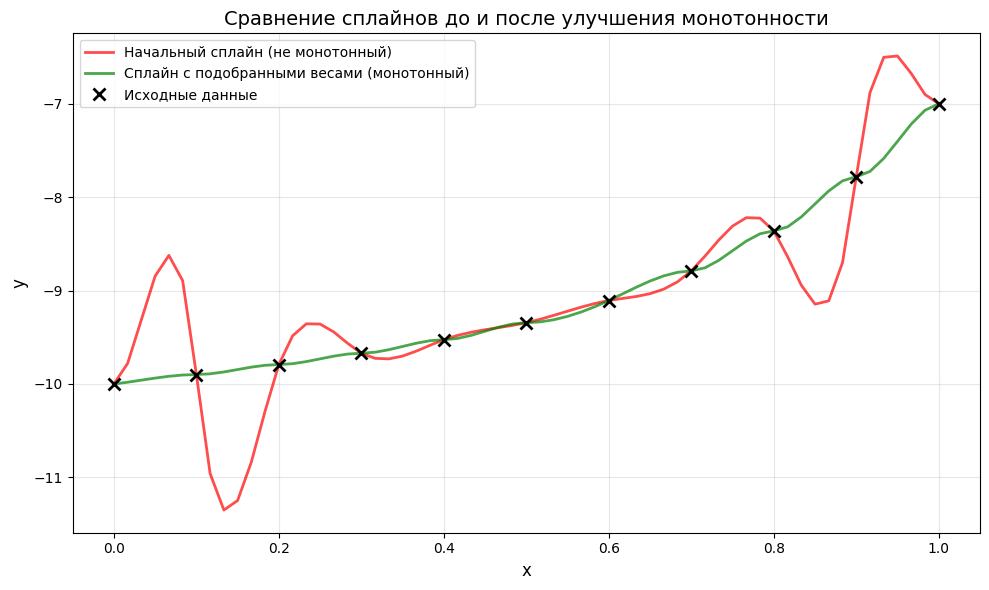


Максимальные ошибки в узлах:
Начальный сплайн: 0.000000e+00
Сплайн с подобранными весами: 0.000000e+00


In [37]:
def f(x):
    return (x * x * x * x * x) + (x * x * x) + x - 10

N = 10
X, H = createEquallySpacedPoints(0, 1, N)
F_file = [f(x) for x in X]  
W_initial = np.ones(len(X)) 

print(f"Узлы: {X}")
print(f"Шаги: {H}")
print(f"Значения функции: {F_file}")
print(f"Начальные веса: {W_initial}")


k_points = 5

print(f"Количество дополнительных точек между узлами: {k_points}")

F_vec = createVecF(X, F_file)
B = createRightSide(H, F_vec)
A_initial = createMatrixWithWeights(N, H, W_initial)
y_initial = solveTridiag(A_initial, B)
splines_initial = buildAllSplines(X, y_initial, F_file)



# Проверяем монотонность начального сплайна
print("\nПроверка монотонности начального сплайна:")
monotonic_info_initial = checkMonotonicity(lambda x: splineValue(x, splines_initial), X)
non_monotonic_initial = findNonMonotonicIntervals(monotonic_info_initial)
print(f"Немонотонные интервалы в начальном сплайне: {len(non_monotonic_initial)}")

for i, info in non_monotonic_initial:
    print(f"  Интервал [{X[i]:.3f}, {X[i+1]:.3f}]: {info['extrema_count']} экстремумов")

# Улучшаем монотонность
W_final, splines_final, success = improveMonotonicity(X, F_file, H, W_initial)

print(f"\n--- РЕЗУЛЬТАТ ---")
print(f"Начальные веса: {[f'{w:.2f}' for w in W_initial]}")
print(f"Финальные веса: {[f'{w:.2f}' for w in W_final]}")
print(f"Улучшение монотонности: {'УСПЕХ' if success else 'ЧАСТИЧНЫЙ УСПЕХ'}")

# Проверяем монотонность финального сплайна
print("\nПроверка монотонности финального сплайна:")
monotonic_info_final = checkMonotonicity(lambda x: splineValue(x, splines_final), X)
non_monotonic_final = findNonMonotonicIntervals(monotonic_info_final)
print(f"Немонотонные интервалы в финальном сплайне: {len(non_monotonic_final)}")

plt.figure(figsize=(10, 6))

XX = insertPointsX(X, k=k_points)

spline_initial_vals = [splineValue(x, splines_initial) for x in XX]
spline_final_vals = [splineValue(x, splines_final) for x in XX]

plt.plot(XX, spline_initial_vals, '-', color='red', linewidth=2, label='Начальный сплайн (не монотонный)', alpha=0.7)
plt.plot(XX, spline_final_vals, '-', color='green', linewidth=2, label='Сплайн с подобранными весами (монотонный)', alpha=0.7)
plt.plot(X, F_file, 'kx', markersize=8, linewidth=2, label='Исходные данные', markeredgewidth=2)

plt.title('Сравнение сплайнов до и после улучшения монотонности', fontsize=14)
plt.xlabel('x', fontsize=12)
plt.ylabel('y', fontsize=12)
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

errors_initial = []
errors_final = []

for i, x in enumerate(X):
    val_initial = splineValue(x, splines_initial)
    val_final = splineValue(x, splines_final)
    
    errors_initial.append(abs(val_initial - F_file[i]))
    errors_final.append(abs(val_final - F_file[i]))

max_error_initial = max(errors_initial)
max_error_final = max(errors_final)

print(f"\nМаксимальные ошибки в узлах:")
print(f"Начальный сплайн: {max_error_initial:.6e}")
print(f"Сплайн с подобранными весами: {max_error_final:.6e}")

with open("monotonic_spline_results.txt", "w") as fout:
    fout.write("УЛУЧШЕНИЕ МОНОТОННОСТИ СПЛАЙНА\n")
    fout.write("=" * 60 + "\n")
    fout.write(f"Начальные веса: {W_initial}\n")
    fout.write(f"Финальные веса: {W_final}\n")
    fout.write(f"Улучшение монотонности: {'УСПЕХ' if success else 'частично лучше стало'}\n\n")
    
    fout.write("Немонотонные интервалы в начальном сплайне:\n")
    for i, info in non_monotonic_initial:
        x_left, x_right = info['interval']
        fout.write(f"  [{x_left:.3f}, {x_right:.3f}]: {info['extrema_count']} экстремумов\n")
    
    fout.write("\nНемонотонные интервалы в финальном сплайне:\n")
    for i, info in non_monotonic_final:
        x_left, x_right = info['interval']
        fout.write(f"  [{x_left:.3f}, {x_right:.3f}]: {info['extrema_count']} экстремумов\n")
    
    fout.write(f"\nМаксимальные ошибки:\n")
    fout.write(f"Начальный сплайн: {max_error_initial:.8e}\n")
    fout.write(f"Сплайн с подобранными весами: {max_error_final:.8e}\n")
    fout.write(f"Количество дополнительных точек между узлами: {k_points}\n")